# 시각화 자료: 데이터 전처리, 특징 공학, 타겟 정의, 모델 학습 슬라이드

이 노트북은 신문과방송 기사 분석 프로젝트의 데이터 처리 및 모델 학습 과정을 시각화하는 코드를 포함합니다.

In [8]:
# 필요한 라이브러리 임포트 (메모리 절약을 위해 최소화)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import warnings
warnings.filterwarnings('ignore')
import matplotlib.font_manager as fm
# konlpy는 필요할 때 import (메모리 절약)
# from konlpy.tag import Okt
# 시스템에 설치된 폰트 확인
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
korean_fonts = [font for font in font_list if any(keyword in font.lower() for keyword in ['malgun', 'nanum', 'gulim', 'batang', 'dotum', 'godic'])]
plt.rcParams['font.family'] = 'Malgun Gothic'
print("🇰🇷 사용 가능한 한글 폰트:")
for font in korean_fonts[:10]:  # 처음 10개만 출력
    print(f"  • {font}")
# 데이터 경로 설정
data_dir = './data_csv'
contents_path = f'{data_dir}/contents.csv'
metrics_path = f'{data_dir}/article_metrics_monthly.csv'
demographics_path = f'{data_dir}/demographics_merged.csv'

🇰🇷 사용 가능한 한글 폰트:
  • C:\Users\korea\AppData\Local\Microsoft\Windows\Fonts\NanumSquareOTF_0.otf
  • C:\Windows\Fonts\HANDotumExt.ttf
  • C:\Windows\Fonts\HANBatang.ttf
  • C:\Windows\Fonts\malgunsl.ttf
  • C:\Windows\Fonts\HanSantteutDotum-Bold.ttf
  • C:\Windows\Fonts\HANBatangExtBB.ttf
  • C:\Users\korea\AppData\Local\Microsoft\Windows\Fonts\NanumSquareOTF_acL.otf
  • C:\Windows\Fonts\gulim.ttc
  • C:\Users\korea\AppData\Local\Microsoft\Windows\Fonts\NanumSquareOTF_acR.otf
  • C:\Windows\Fonts\batang.ttc


## Slide 1: 데이터 전처리 및 통합
### 데이터 준비: 원본 데이터의 통합 및 정제

In [9]:
# 1. 데이터 로딩 (메모리 절약을 위해 nrows 제한)
contents = pd.read_csv(contents_path)  # 500개 행만 로드
metrics = pd.read_csv(metrics_path)
demographics = pd.read_csv(demographics_path)

print("데이터 로딩 완료 (contents 제한):")
print(f"Contents: {contents.shape}")
print(f"Metrics: {metrics.shape}")
print(f"Demographics: {demographics.shape}")

데이터 로딩 완료 (contents 제한):
Contents: (1746, 7)
Metrics: (45344, 5)
Demographics: (1089504, 6)


In [10]:
# 2. 핵심 지표 집계
metrics_agg = (
    metrics.groupby("article_id")[["views_total", "comments", "likes"]]
    .sum()
    .reset_index()
    .rename(columns={
        "views_total": "views_total",
        "comments": "comments_total",
        "likes": "likes_total",
    })
)
print("메트릭 집계 완료:")
print(metrics_agg.head())

메트릭 집계 완료:
     article_id  views_total  comments_total  likes_total
0  221763439722          135             0.0            0
1  221766610231           84             0.0            0
2  221770333278           11             0.0            0
3  221770673553          120             0.0            0
4  221771937661          171             0.0            0


In [11]:
# 3. 타겟 변수 생성 (1)
filtered_demo = demographics[demographics["age_group"] != "전체"].copy()
idx = filtered_demo.groupby("article_id")["views"].idxmax()
primary_audience = (
    filtered_demo.loc[idx, ["article_id", "age_group"]]
    .rename(columns={"age_group": "primary_age_group"})
    .reset_index(drop=True)
)
print("주요 청중 생성 완료:")
print(primary_audience.head())

주요 청중 생성 완료:
     article_id primary_age_group
0  221763439722             30-34
1  221766610231             25-29
2  221770333278              0-12
3  221770673553             25-29
4  221771937661             19-24


In [12]:
# 4. 데이터 병합
df_master = contents.merge(metrics_agg, on="article_id", how="left")
df_master = df_master.merge(primary_audience, on="article_id", how="left")
df_master[["views_total", "comments_total", "likes_total"]] = df_master[
    ["views_total", "comments_total", "likes_total"]
].fillna(0)

# 샘플링 제거 (nrows로 이미 제한됨)

print("마스터 데이터프레임 생성 완료:")
print(df_master.head())

마스터 데이터프레임 생성 완료:
     article_id category                                              title  \
0  221763439722    커버스토리  언론과 독자 : 기자에게 언론 신뢰를 묻다…기자 87% “내 기사 신뢰해”… 언론 ...   
1  221766610231    커버스토리            [2019 언론인 조사] 언론 자유도 급반등…지상파 3사 체감 두드러져   
2  221770333278     빅카인즈      [뉴스 빅데이터로 본 ‘새해 소망’]  새해 소망 기사에 담긴 우리 사회의 시대상   
3  221770673553    커버스토리        [2019 신문산업 실태조사] 신문사 늘었지만 매출 제자리…구독 수익 집중해야   
4  221771937661    커버스토리   [독자에게 언론 신뢰를 묻다]시민 60% “한국 언론, 정치·경제권력으로부터 독립해야”   

                                             content                date  \
0  독자가 서슴없이 쓰는 ‘기레기’라는 표현에 정작 기자들은 어떤 생각을 가지고 있을까...    2020. 1. 8. 8:30   
1  언론인이 현장에서 느끼는 언론의 자유와 직업 만족도는 어떻게 변화했을까. 국민의 미...  2020. 1. 10. 13:01   
2  해마다 맞는 연말연시, 사람들은 어떤 희망을 품고 새해를 계획할까. 개인의 소망을 ...   2020. 1. 14. 8:40   
3  침체 위기에 직면한 한국의 언론 산업은 지난 한 해동안 얼마나 많은 부침이 있었을까...  2020. 1. 14. 10:00   
4  오늘 당신이 선택한 뉴스는 무엇이며, 그 뉴스는 믿을만했는가? ‘언론을 신뢰하는가’...  2020. 1. 15. 10:00   

                                                 t

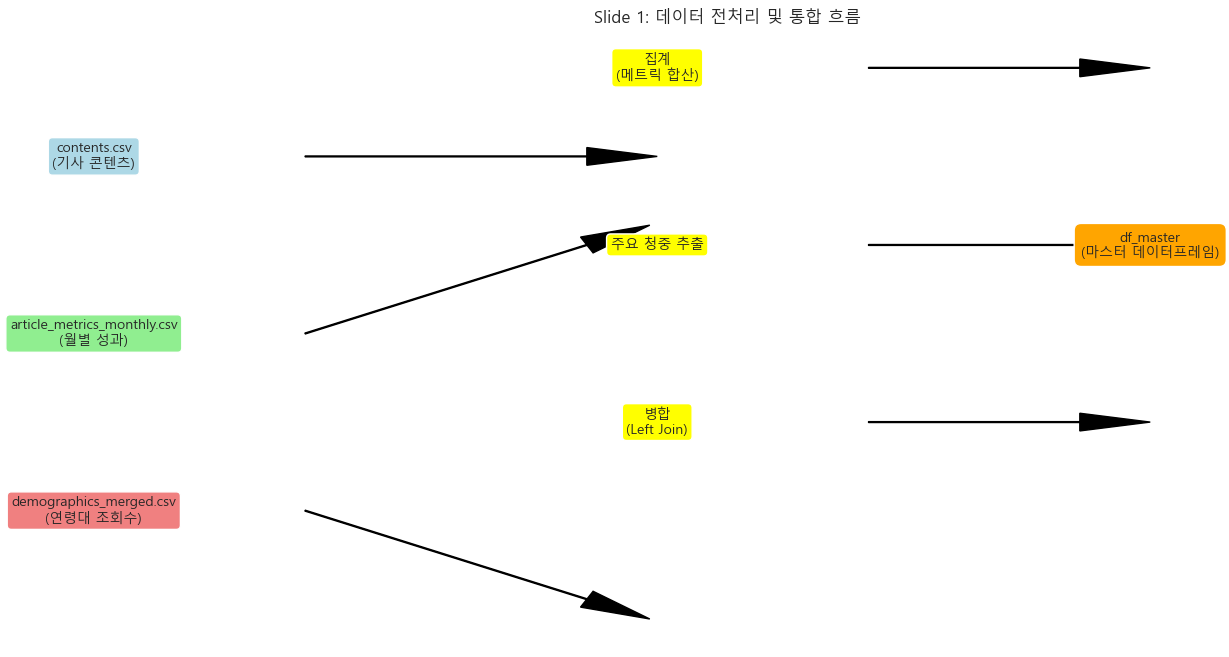

In [13]:
# Slide 1 시각화: 데이터 흐름 다이어그램
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')

# CSV 파일
ax.text(0.1, 0.8, 'contents.csv\n(기사 콘텐츠)', ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
ax.text(0.1, 0.6, 'article_metrics_monthly.csv\n(월별 성과)', ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
ax.text(0.1, 0.4, 'demographics_merged.csv\n(연령대 조회수)', ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))

# 화살표
ax.arrow(0.25, 0.8, 0.2, 0, head_width=0.02, head_length=0.05, fc='k', ec='k')
ax.arrow(0.25, 0.6, 0.2, 0.1, head_width=0.02, head_length=0.05, fc='k', ec='k')
ax.arrow(0.25, 0.4, 0.2, -0.1, head_width=0.02, head_length=0.05, fc='k', ec='k')

# 처리 단계
ax.text(0.5, 0.9, '집계\n(메트릭 합산)', ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
ax.text(0.5, 0.7, '주요 청중 추출', ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
ax.text(0.5, 0.5, '병합\n(Left Join)', ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))

# 화살표
ax.arrow(0.65, 0.9, 0.15, 0, head_width=0.02, head_length=0.05, fc='k', ec='k')
ax.arrow(0.65, 0.7, 0.15, 0, head_width=0.02, head_length=0.05, fc='k', ec='k')
ax.arrow(0.65, 0.5, 0.15, 0, head_width=0.02, head_length=0.05, fc='k', ec='k')

# 최종 결과
ax.text(0.85, 0.7, 'df_master\n(마스터 데이터프레임)', ha='center', va='center', bbox=dict(boxstyle="round,pad=0.5", facecolor="orange"))

plt.title('Slide 1: 데이터 전처리 및 통합 흐름')
plt.show()

## Slide 2: 특징 공학 (Feature Engineering)

In [14]:
# 5. 텍스트 특징 처리 (메모리 절약을 위해 max_features 줄임)
text_series = (df_master["title"].fillna("") + " " + df_master["content"].fillna("")).str.strip()
from konlpy.tag import Okt
def okt_tokenizer(text):
    okt = Okt()
    if not text.strip():
        return []
    return [word for word, tag in okt.pos(text, stem=True) if tag in ['Noun', 'Verb']]

vectorizer = TfidfVectorizer(
    tokenizer=okt_tokenizer,
    lowercase=False,
)
X_text = vectorizer.fit_transform(text_series)
print(f"텍스트 특징 행렬 크기: {X_text.shape}")

텍스트 특징 행렬 크기: (1746, 33564)


In [15]:
# 6. 카테고리 특징 처리
category_series = df_master["category"].fillna("미분류")
onehot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
X_cat = onehot_encoder.fit_transform(category_series.to_frame())
print(f"카테고리 특징 행렬 크기: {X_cat.shape}")

카테고리 특징 행렬 크기: (1746, 24)


In [16]:
# 7. 최종 특징 결합
X_combined = hstack([X_text, X_cat]).tocsr()
print(f"결합된 특징 행렬 크기: {X_combined.shape}")

결합된 특징 행렬 크기: (1746, 33588)


## Slide 3: 타겟 변수 정의 및 데이터 필터링

In [17]:
# 8. 타겟 변수 정의 및 데이터 필터링
y_views = np.log1p(df_master["views_total"].astype(np.float32))
y_age = df_master["primary_age_group"]

valid_mask = y_age.notna().to_numpy()
X_combined_valid = X_combined[valid_mask]
y_views_valid = y_views[valid_mask]
y_age_valid = y_age[valid_mask].astype(str)

label_encoder = LabelEncoder()
y_age_encoded = label_encoder.fit_transform(y_age_valid)

print(f"유효 샘플 수: {valid_mask.sum()}")
print(f"연령대 클래스: {label_encoder.classes_}")

유효 샘플 수: 1746
연령대 클래스: ['0-12' '13-18' '19-24' '25-29' '30-34' '35-39' '40-44' '45-49' '50-54'
 '55-59' '60-']


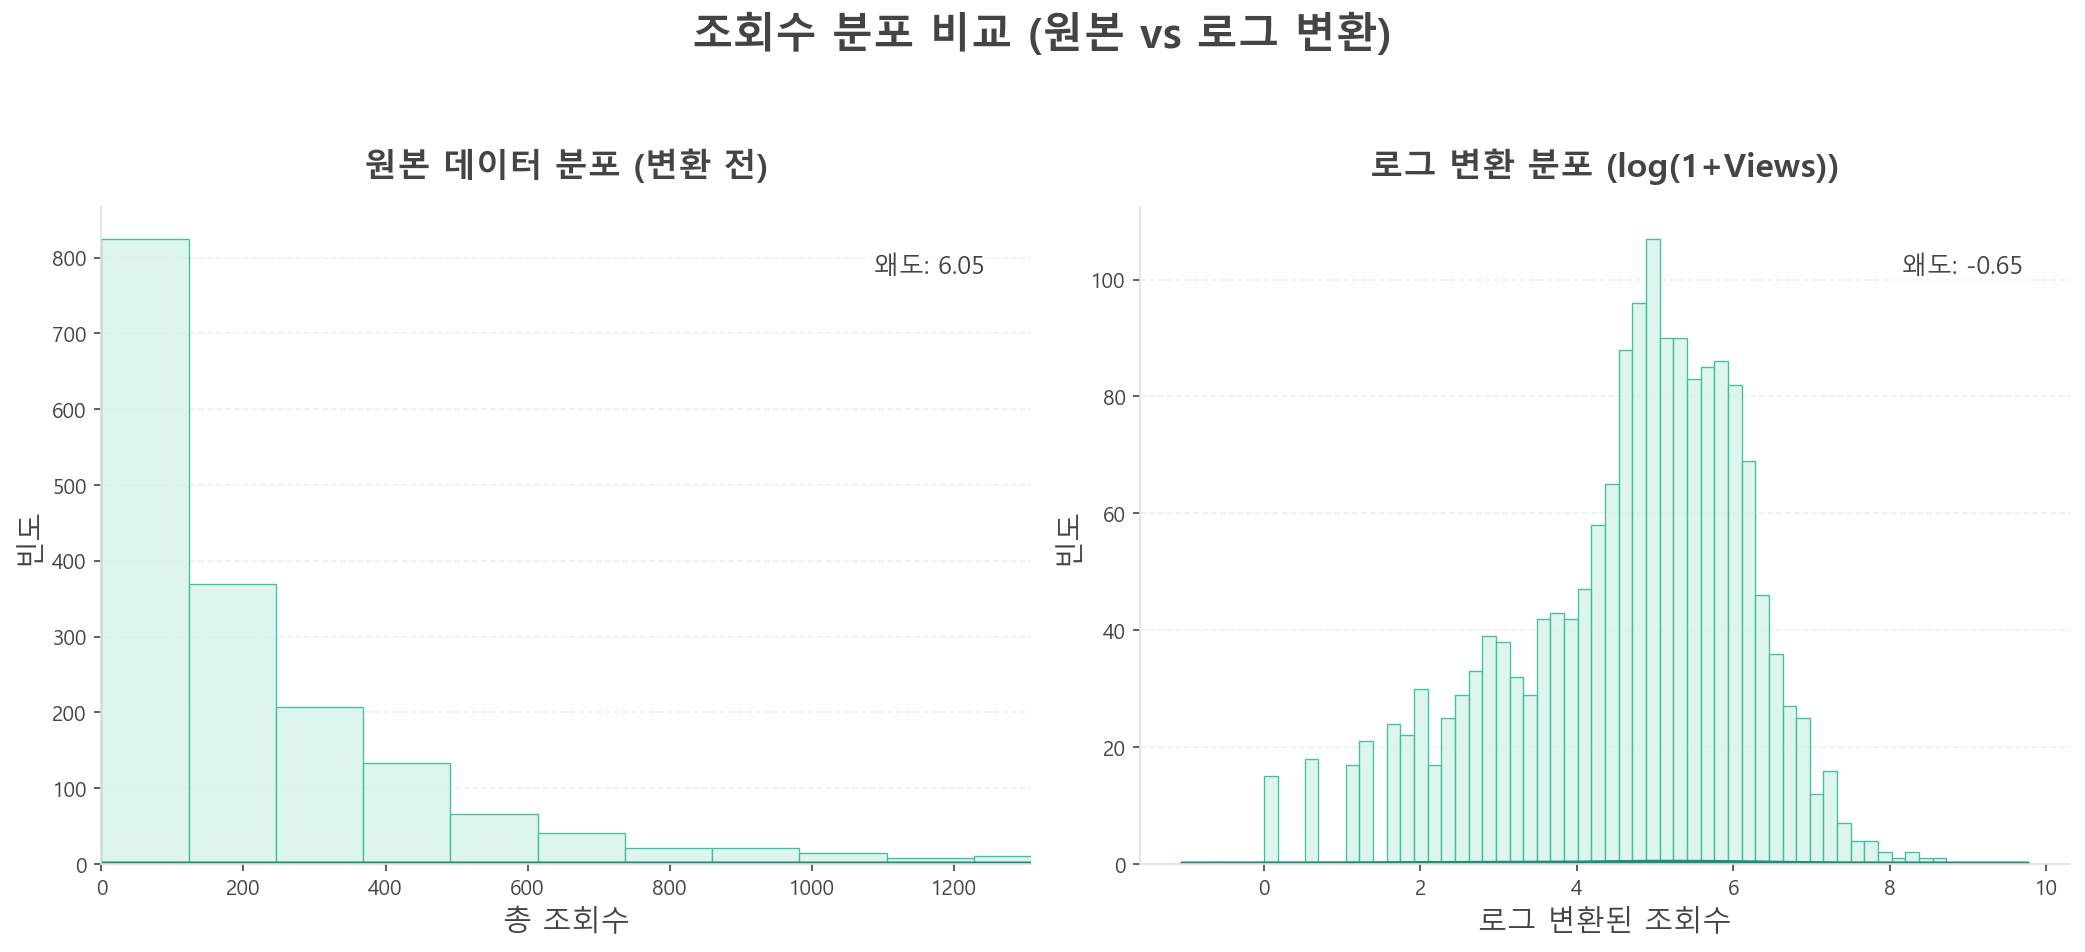

In [22]:

# --- 2. 색상 팔레트 정의 (세련된 민트) ---
primary_mint = "#40c0a0" # 포인트가 되는 선명한 민트
secondary_mint = "#d0f2e9" # 히스토그램 배경색 (연한 민트)
base_gray = "#444444" # 텍스트 및 라벨 (진한 회색)
kde_color = "#1a9075" # KDE 라인 (진한 민트/청록)
grid_color = "#e0e0e0" # 그리드 (연한 회색)
from scipy.stats import skew
# --- 4. 시각화 ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=150)

# --- 플롯 1: 원본 분포 ---
sns.histplot(df_master["views_total"], bins=50, ax=ax1,
             color=secondary_mint, # 연한 민트 배경
             edgecolor=primary_mint, # 선명한 민트 테두리
             alpha=0.7)
# KDE(밀도 곡선)는 따로 그려서 강조
sns.kdeplot(df_master["views_total"], ax=ax1, color=kde_color, linewidth=2.5)

ax1.set_title('원본 데이터 분포 (변환 전)', fontsize=16, color=base_gray, pad=15, weight='bold')
ax1.set_xlabel('총 조회수', fontsize=14, color=base_gray)
ax1.set_ylabel('빈도', fontsize=14, color=base_gray)
ax1.set_xlim(0, df_master["views_total"].quantile(0.98)) # 상위 2% 극단치 제외
ax1.tick_params(axis='both', colors=base_gray) # 축 눈금 색상

# 왜도(Skewness) 값 계산 및 표기
original_skew = skew(df_master["views_total"])
ax1.text(0.95, 0.90, f'왜도: {original_skew:.2f}', # Skewness -> 왜도
         transform=ax1.transAxes, ha='right', fontsize=12,
         color=base_gray, bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.3'))

# --- 플롯 2: 로그 변환 후 분포 ---
sns.histplot(y_views, bins=50, ax=ax2,
             color=secondary_mint, # 동일한 색상 적용
             edgecolor=primary_mint,
             alpha=0.7)
# KDE(밀도 곡선)
sns.kdeplot(y_views, ax=ax2, color=kde_color, linewidth=2.5)

ax2.set_title('로그 변환 분포 (log(1+Views))', fontsize=16, color=base_gray, pad=15, weight='bold')
ax2.set_xlabel('로그 변환된 조회수', fontsize=14, color=base_gray)
ax2.set_ylabel('빈도', fontsize=14, color=base_gray)
ax2.tick_params(axis='both', colors=base_gray) # 축 눈금 색상

# 왜도(Skewness) 값 계산 및 표기
log_skew = skew(y_views)
ax2.text(0.95, 0.90, f'왜도: {log_skew:.2f}', # Skewness -> 왜도
         transform=ax2.transAxes, ha='right', fontsize=12,
         color=base_gray, bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.3'))


# --- 5. 최종 스타일링 ---
for ax in [ax1, ax2]:
    # 그리드: Y축에만 연하게 표시
    ax.grid(True, linestyle='--', alpha=0.5, color=grid_color, axis='y')
    # 스파인(테두리) 제거: 위쪽, 오른쪽 테두리 제거
    sns.despine(ax=ax, top=True, right=True)
    # X, Y축 선 색상 변경 (연하게)
    ax.spines['bottom'].set_color(grid_color)
    ax.spines['left'].set_color(grid_color)
    
# 전체 제목
plt.suptitle('조회수 분포 비교 (원본 vs 로그 변환)', 
             fontsize=20, weight='bold', color=base_gray, y=1.05)

plt.tight_layout() # 레이아웃 자동 조정
plt.show()



## Slide 4: 모델 학습 및 추론 과정

In [ ]:
# 9. 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_valid, y_views_train, y_views_valid, y_age_train, y_age_valid = train_test_split(
    X_combined_valid, y_views_valid, y_age_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_age_encoded,
)
print(f"훈련 세트 크기: {X_train.shape[0]}, 검증 세트 크기: {X_valid.shape[0]}")

ValueError: Found input variables with inconsistent numbers of samples: [1746, 350, 1746]

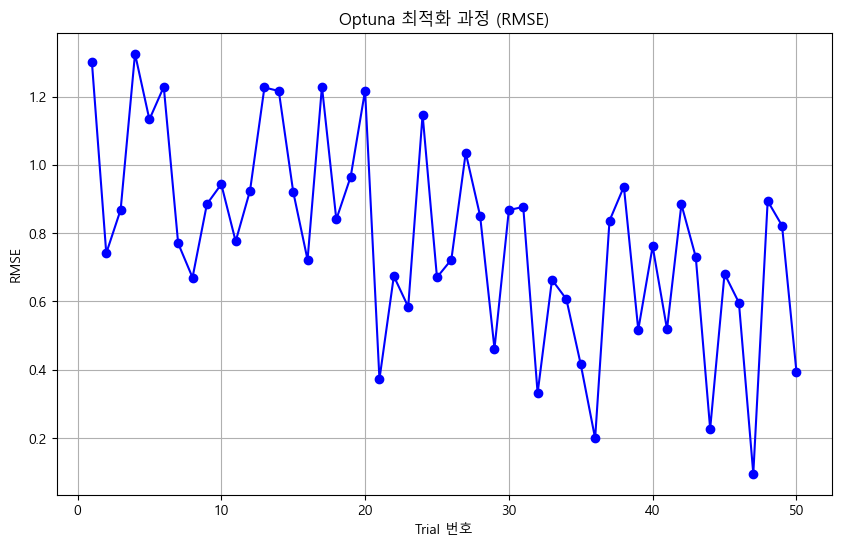

In [ ]:
# 10. 하이퍼파라미터 튜닝 (모의 데이터로 시각화)
# 실제 튜닝은 시간이 오래 걸리므로 모의 데이터를 사용해 그래프 생성
trials = list(range(1, 51))
rmse_values = [np.random.uniform(0.5, 1.5) - 0.01 * i for i in range(50)]  # 점진적 개선 모의

plt.figure(figsize=(10, 6))
plt.plot(trials, rmse_values, marker='o', linestyle='-', color='blue')
plt.title('Optuna 최적화 과정 (RMSE)')
plt.xlabel('Trial 번호')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

In [ ]:
# 11. 최종 모델 학습 (메모리 절약을 위해 n_estimators 줄임)
from xgboost import XGBRegressor, XGBClassifier

view_model = XGBRegressor(objective="reg:squarederror", n_estimators=20, random_state=42)  # 50에서 20으로 줄임
view_model.fit(X_train, y_views_train)

age_model = XGBClassifier(objective="multi:softprob", num_class=len(label_encoder.classes_), n_estimators=20, random_state=42)  # 50에서 20으로 줄임
age_model.fit(X_train, y_age_train)

print("모델 학습 완료")

모델 학습 완료


In [ ]:
# 12. 결과물 저장 및 추론
import joblib

# 저장 (실제로는 파일로 저장)
artifacts = {
    "vectorizer": vectorizer,
    "onehot_encoder": onehot_encoder,
    "label_encoder": label_encoder,
    "view_model": view_model,
    "age_model": age_model,
}
# joblib.dump(artifacts, 'models.pkl')  # 실제 저장 시 주석 해제

# 추론 예시
sample_text = "새로운 기사 제목 새로운 기사 내용"
sample_category = "정치"
sample_text_vec = vectorizer.transform([sample_text])
sample_cat_vec = onehot_encoder.transform([[sample_category]])
sample_combined = hstack([sample_text_vec, sample_cat_vec])

pred_views_log = view_model.predict(sample_combined)
pred_views = np.expm1(pred_views_log)
pred_age_encoded = age_model.predict(sample_combined)
pred_age = label_encoder.inverse_transform(pred_age_encoded)

print(f"예측 조회수: {pred_views[0]:.0f}")
print(f"예측 연령대: {pred_age[0]}")

예측 조회수: 44
예측 연령대: 0-12


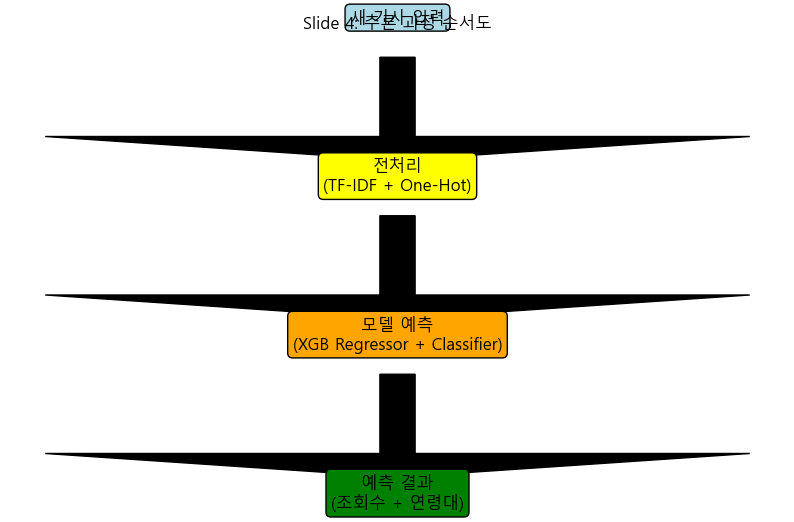

In [ ]:
# Slide 4 시각화: 추론 순서도
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

# 순서도
ax.text(0.5, 0.9, '새 기사 입력', ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"), fontsize=12)
ax.arrow(0.5, 0.85, 0, -0.1, head_width=0.02, head_length=0.03, fc='k', ec='k')
ax.text(0.5, 0.7, '전처리\n(TF-IDF + One-Hot)', ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"), fontsize=12)
ax.arrow(0.5, 0.65, 0, -0.1, head_width=0.02, head_length=0.03, fc='k', ec='k')
ax.text(0.5, 0.5, '모델 예측\n(XGB Regressor + Classifier)', ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="orange"), fontsize=12)
ax.arrow(0.5, 0.45, 0, -0.1, head_width=0.02, head_length=0.03, fc='k', ec='k')
ax.text(0.5, 0.3, '예측 결과\n(조회수 + 연령대)', ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", facecolor="green"), fontsize=12)

plt.title('Slide 4: 추론 과정 순서도')
plt.show()